In [1]:
import subprocess

import fiona
import rasterio

In [2]:
input_image_fn = "data/pre/images/pre.tif"
input_label_fn = "data/pre/annotations/pre_labels.geojson"

output_mask_fn = "data/pre/masks/pre_mask.tif"

## Create label masks

In [3]:
unique_classes = set()
with fiona.open(input_label_fn) as f:
    for row in f:
        unique_classes.add(row["properties"]["class"])

In [4]:
class_names = sorted(list(unique_classes))

In [5]:
class_to_idx_map = {
    class_name: i + 1  # we add one to reserve class 0 as the nodata class
    for i, class_name in enumerate(class_names)
}

In [6]:
# get the bounds of the input image -- we use these to 
with rasterio.open(input_image_fn) as f:
    left, bottom, right, top = f.bounds
    width = f.width
    height = f.height

In [7]:
command = [
    "gdal_rasterize",
    "-q",
    "-ot", "Byte",
    "-a_nodata", "0",
    "-init", "0",
    "-burn", str(class_to_idx_map[class_names[0]]),
    "-of", "GTiff",
    "-co", "TILED=YES",
    "-co", "BLOCKXSIZE=512",
    "-co", "BLOCKYSIZE=512",
    "-co", "INTERLEAVE=PIXEL",
    "-where", f"class='{class_names[0]}'",
    "-te", str(left), str(bottom), str(right), str(top),
    "-ts", str(width), str(height),
    "-co", "COMPRESS=LZW",
    "-co", "PREDICTOR=2",
    "-co", "BIGTIFF=YES",
    input_label_fn,
    output_mask_fn,
]
assert subprocess.call(command) == 0

In [8]:
for i in range(1,len(class_names)):
    command = [
        "gdal_rasterize",
        "-q",
        "-b", "1",
        "-burn", str(class_to_idx_map[class_names[i]]),
        "-where", f"class='{class_names[i]}'",
        input_label_fn,
        output_mask_fn,
    ]
    assert subprocess.call(command) == 0

## Training

In [9]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples
from torchgeo.samplers import RandomBatchGeoSampler, RandomGeoSampler
from torchgeo.trainers import SemanticSegmentationTask
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [10]:
def preprocess(sample):
    if "image" in sample:
        sample["image"] = (sample["image"] / 255.0).float()
    if "mask" in sample:
        sample["mask"] = sample["mask"].squeeze().long()
    del sample["bbox"]
    return sample

class SegmentationDataModule(pl.LightningDataModule):

    def __init__(
        self,
        image_fn_root,
        mask_fn_root,
        batch_size=64,
        patch_size=256,
        num_workers=6,
        train_batches_per_epoch=512,
        val_batches_per_epoch=32,
    ):
        super().__init__()

        self.image_fn_root = image_fn_root
        self.mask_fn_root = mask_fn_root
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.train_batches_per_epoch = train_batches_per_epoch
        self.val_batches_per_epoch = val_batches_per_epoch

    def setup(self, stage=None):
        self.image_ds = RasterDataset(
            self.image_fn_root,
            transforms=preprocess
        )
        
        self.mask_ds = RasterDataset(
            self.mask_fn_root,
            transforms=preprocess
        )
        self.mask_ds.is_image = False

        self.ds = self.image_ds & self.mask_ds

    def train_dataloader(self):
        sampler = RandomBatchGeoSampler(
            self.ds, size=self.patch_size, batch_size=self.batch_size, length=self.train_batches_per_epoch * self.batch_size
        )

        return DataLoader(
            self.ds,
            batch_sampler=sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples
        )

    def val_dataloader(self):
        sampler = RandomBatchGeoSampler(
            self.ds, size=self.patch_size, batch_size=self.batch_size, length=self.val_batches_per_epoch * self.batch_size
        )

        return DataLoader(
            self.ds,
            batch_sampler=sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples
        )

In [11]:
experiment_dir = "results/"
experiment_name = "pre_model_1"

gpu_id = 0
device = torch.device(f"cuda:{gpu_id}")

In [12]:
datamodule = SegmentationDataModule(
    "data/pre/images/",
    "data/pre/masks/",
    batch_size=32
)

In [13]:
task = SemanticSegmentationTask(
    segmentation_model="unet",
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    num_classes=len(class_names) + 1,  # +1 class because we include 0 as a nodata class
    loss="ce",
    ignore_index=0,
    learning_rate=0.0001,
    learning_rate_schedule_patience=10
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=experiment_dir,
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
)

tb_logger = TensorBoardLogger(
    save_dir="logs/",
    name=experiment_name
)

In [ ]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=[tb_logger],
    default_root_dir=experiment_dir,
    min_epochs=10,
    max_epochs=50,
    accelerator='gpu',
    devices=[gpu_id]
)

_ = trainer.fit(model=task, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/hackathon/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/calebrobinson/ssdprivate/hackathon/results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Converting RasterDataset resolution from 4.629629629632204e-06 to 4.629629629631084e-06


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Unet             | 32.5 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.086   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/envs/hackathon/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:98: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

## Run inference with our trained model

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
model = task.model
model = model.to(device)
model = model.eval()

In [31]:
with rasterio.open("data/pre/images/pre.tif") as f:
    image = f.read()
    
with rasterio.open("data/pre/masks/pre_mask.tif") as f:
     mask = f.read().squeeze()

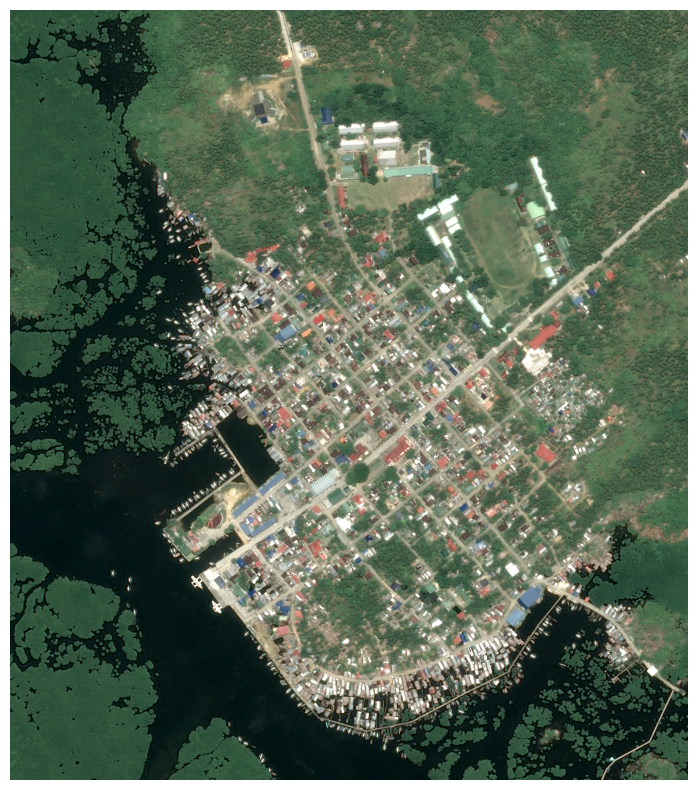

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(np.rollaxis(image[:,:2500, :2200], 0, 3))
plt.axis("off")
plt.show()
plt.close()

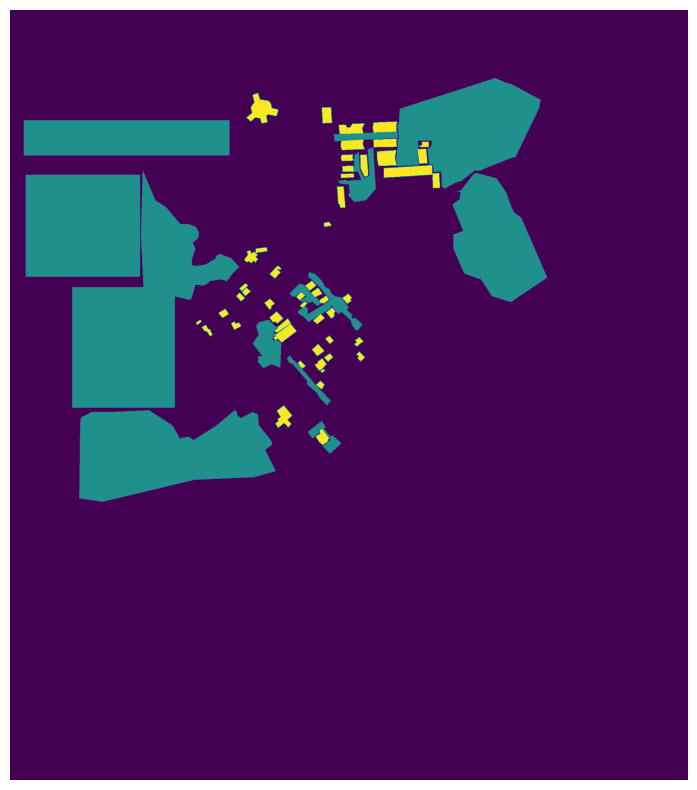

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(mask[:2500, :2200], vmin=0, vmax=2)
plt.axis("off")
plt.show()
plt.close()

In [22]:
image = (torch.from_numpy(image).unsqueeze(0) / 255.0).float()

In [24]:
image = image.to(device)

In [27]:
with torch.inference_mode():
    predictions = model(image).argmax(axis=1).cpu().numpy().squeeze()

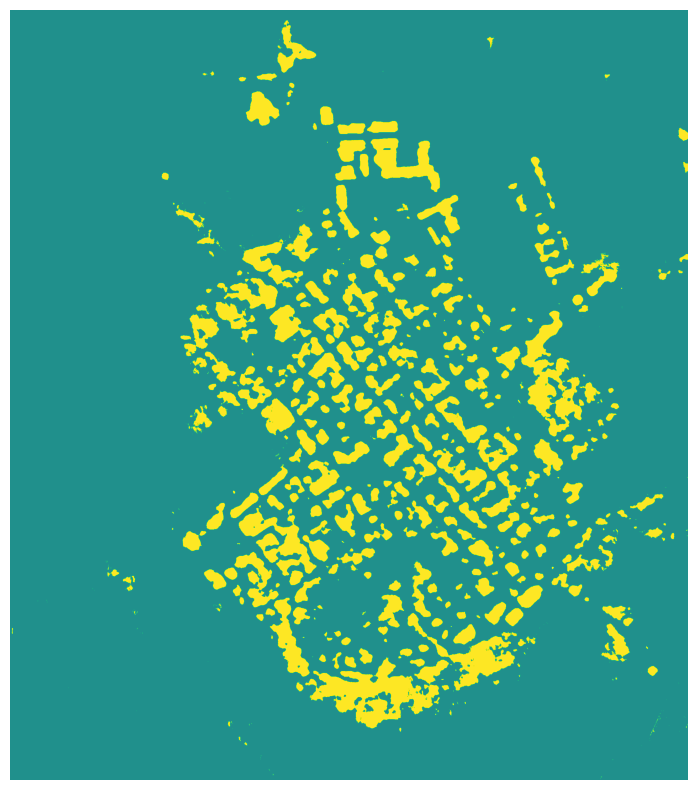

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(predictions[:2500, :2200], vmin=0, vmax=2)
plt.axis("off")
plt.show()
plt.close()